### Calculation of Area and Circumference for a 1 SD Confidence Ellipse from $\Sigma$

The area $A$ of the 1 standard deviation (SD) confidence ellipse for a bivariate normal distribution can be calculated using the formula:

$ A = 2 \pi \sqrt{\det(\Sigma)} $

where 
$\Sigma$ is the covariance matrix and 
$\deg(\Sigma)$ is the determinant of sigma

$\Sigma = \begin{pmatrix}
\sigma_x^2 & \rho \sigma_x \sigma_y \\
\rho \sigma_x \sigma_y & \sigma_y^2
\end{pmatrix}$

and 


$\det(\Sigma) = \sigma_x^2 \sigma_y^2 (1 - \rho^2) $

$\rho$ is correlation coefficient and is calculated directly from $\Sigma$

$\rho = \frac{\rho \sigma_x \sigma_y}{\sigma_x \sigma_y}$


In [1]:
import sys
import numpy as np
from numpy import linalg as la
import pandas as pd
import polars as pl

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

sys.path.append('../src')
from fetch_savant import StatcastDataHandler



### A couple convenience functions

In [121]:

def plot_confidence_ellipse(mu, cov, alph, ax, clabel=None, label_bg='white', clabel_size=10, label_position='top', **kwargs):
    """Display a confidence ellipse of a bivariate normal distribution
    
    Arguments:
        mu {array-like of shape (2,)} -- mean of the distribution
        cov {array-like of shape(2,2)} -- covariance matrix
        alph {float btw 0 and 1} -- level of confidence
        ax {plt.Axes} -- axes on which to display the ellipse
        clabel {str} -- label to add to ellipse (default: {None})
        label_bg {str} -- background of clabel's textbox
        clabel_size {int} -- font size of the clabel (default: {10})
        label_position {str} -- position of the label ('top' or 'bottom', default: 'top')

        kwargs -- other arguments given to class Ellipse
    """
    c = -2 * np.log(1 - alph)  # quantile at alpha of the chi_squarred distr. with df = 2
    Lambda, Q = la.eig(cov)  # eigenvalues and eigenvectors (col. by col.)
    
    ## Compute the attributes of the ellipse
    width, heigth = 2 * np.sqrt(c * Lambda)
    # compute the value of the angle theta (in degree)
    theta = 180 * np.arctan(Q[1,0] / Q[0,0]) / np.pi if cov[1,0] else 0
        
    ## Create the ellipse
    if 'fc' not in kwargs.keys():
        kwargs['fc'] = 'None'
    level_line = Ellipse(mu, width, heigth, angle=theta, **kwargs)
    
    ## Display a label 'clabel' on the ellipse
    if clabel:
        col = kwargs['ec'] if 'ec' in kwargs.keys() and kwargs['ec'] != 'None' else 'black'  # color of the text
        if label_position == 'top':
            pos = Q[:,1] * np.sqrt(c * Lambda[1]) + mu  # position along the height (top)
        else:
            pos = -Q[:,1] * np.sqrt(c * Lambda[1]) + mu  # position along the height (bottom)
        
        ax.text(*pos, clabel, color=col,
           rotation=theta, ha='center', va='center', rotation_mode='anchor', # rotation
           fontsize=clabel_size,  # set the font size
           bbox=dict(boxstyle='round',ec='None',fc=label_bg, alpha=1)) # white box
        
    return ax.add_patch(level_line)


In [77]:
def extract_sigma(df):
    
    sig1 = df['HRA_deg_var'].to_numpy()
    sig2 = df['VRA_deg_var'].to_numpy()
    cov = df['HRA_VRA_cov'].to_numpy()

    SIGMA = np.hstack([sig1[:,None],cov[:,None],cov[:,None],sig2[:,None]]).reshape(-1,2,2)

    return(SIGMA)


### Load statcast data

In [33]:

# load handler
handler = StatcastDataHandler()

#handler.update_local_sc(just_current=True)
# convenience function for fetching seasons, game types
sc = handler.fetch_statcast(start_year=2024,game_types=['R'])

sc = pl.from_pandas(sc)


Fetching: [2024]


### Calculate release angles from release direction vector

In [49]:
# get release metrics
sc_angle = (
    sc
    .with_columns((60.5 - pl.col('release_extension')).alias('yR'))
    .with_columns(( (-pl.col('vy0') - (pl.col('vy0')**2 - 2 * pl.col('ay') * (50 - pl.col('yR')) ).sqrt() ) / pl.col('ay')).alias('tR'))
    .with_columns(
        (pl.col('vx0') + pl.col('ax') * pl.col('tR')).alias('vxR'),
        (pl.col('vy0') + pl.col('ay') * pl.col('tR')).alias('vyR'),
        (pl.col('vz0') + pl.col('az') * pl.col('tR')).alias('vzR')
    )
    .with_columns(
        pl.arctan2('vyR','vxR').alias('HRA'),
        pl.arctan2('vyR','vzR').alias('VRA')
    )
    .with_columns(
        (pl.col('HRA').degrees() + 90).alias('HRA_deg'),
        (pl.col('VRA').degrees() + 90).alias('VRA_deg')
    )
    .drop_nulls(subset=['pitch_type', 'vxR', 'vyR', 'vzR','HRA_deg','VRA_deg'])
)

#### Collapse by pitcher, pitch type, and batter handedness. Then calculate area of 1-sigma conf ellipse of bivariate norm HRA-VRA

In [71]:
# collapse by pitcher, pitch type, and batter handedness
# calculate area of 1-sigma conf ellipse of bivariate norm HRA-VRA
sc_agg = (
    sc_angle
    .filter(pl.len().over(['pitcher_name','pitcher','pitch_type','stand']) >= 150)
    .filter(~pl.col('HRA_deg').is_nan())
    .filter(~pl.col('VRA_deg').is_nan())
    .group_by(['pitcher_name','pitcher','pitch_type','stand'])
    .agg(
        pl.mean('HRA_deg'),
        pl.mean('VRA_deg'),
        pl.var('HRA_deg').alias('HRA_deg_var'),
        pl.var('VRA_deg').alias('VRA_deg_var'),
        pl.cov('HRA_deg','VRA_deg').alias('HRA_VRA_cov'),
        pl.len().alias('n')
    )
    .with_columns(
        (pl.col('HRA_VRA_cov')/(pl.col('HRA_deg_var').sqrt() * pl.col('VRA_deg_var').sqrt())).alias('HRA_VRA_corr')
    )
    .with_columns(
        (pl.col('HRA_deg_var') * pl.col('VRA_deg_var') * (1 - pl.col('HRA_VRA_corr')**2)).alias('HRA_VRA_det')
    )
    .with_columns(
        (2 * np.pi * (pl.col('HRA_VRA_det')).sqrt()).alias('HRA_VRA_area')
    )
    .filter(~( pl.col('HRA_deg_var').is_null() | pl.col('VRA_deg_var').is_null() ))
) 

In [73]:
sc_agg.filter(pl.col('n') > 300).filter(pl.col('pitch_type') == 'FF').sort('HRA_VRA_area',descending = False)

pitcher_name,pitcher,pitch_type,stand,HRA_deg,VRA_deg,HRA_deg_var,VRA_deg_var,HRA_VRA_cov,n,HRA_VRA_corr,HRA_VRA_det,HRA_VRA_area
str,i64,str,str,f64,f64,f64,f64,f64,u32,f64,f64,f64
"""Joe Ryan""",657746,"""FF""","""R""",4.053567,-0.44764,0.467067,0.510697,-0.130566,530,-0.267338,0.221482,2.956986
"""Kutter Crawford""",676710,"""FF""","""L""",1.90128,-2.277641,0.368078,0.67977,-0.153862,324,-0.307595,0.226535,2.990528
"""Mitch Keller""",656605,"""FF""","""L""",3.127093,-1.529594,0.554483,0.509862,-0.235774,377,-0.44343,0.227121,2.994388
null,625643,"""FF""","""R""",2.536916,-2.356733,0.467139,0.520459,-0.122003,392,-0.247431,0.228242,3.001772
"""Chris Paddack""",663978,"""FF""","""R""",3.653309,-2.371935,0.356123,0.745995,-0.158931,335,-0.308347,0.240407,3.080729
…,…,…,…,…,…,…,…,…,…,…,…,…
"""Zac Gallen""",668678,"""FF""","""R""",3.40653,-2.383203,0.79141,0.861981,-0.204967,433,-0.248161,0.640169,5.027211
"""Freddy Peralta""",642547,"""FF""","""R""",3.714707,-1.610493,0.793068,0.970655,-0.341614,545,-0.389357,0.653095,5.077714
"""Zac Gallen""",668678,"""FF""","""L""",3.451122,-2.180563,0.664751,1.055954,0.138825,336,0.165697,0.682674,5.191425


### Filter for just FF

In [172]:
pitch_type = 'FF'
sc_agg_FF = (
    sc_agg
    .filter(pl.col('n') > 300)
    .filter(pl.col('stand') == 'R')
    .filter(pl.col('pitch_type') == pitch_type)
    .filter(pl.col('pitcher_name') != 'None')
    .sort('HRA_VRA_area',descending = False)
)
names = sc_agg_FF['pitcher_name'].to_numpy()
sigmas = extract_sigma(sc_agg_FF)


### Plots!

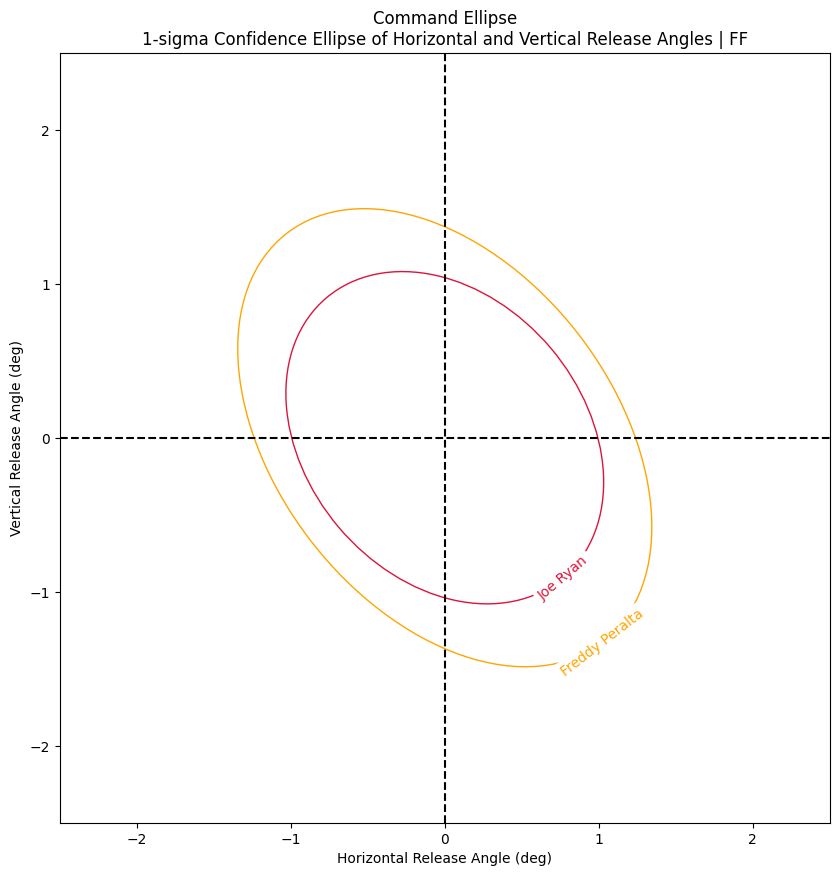

In [173]:
fig, ax = plt.subplots(figsize=(10,10))

mu = np.array([0.0,0.0])

idx1 = 0
idx2 = -2

plot_confidence_ellipse(mu, sigmas[idx1] ,.68, ax, ec='crimson', clabel=names[idx1])
plot_confidence_ellipse(mu, sigmas[idx2] ,.68, ax, ec='orange', clabel=names[idx2])

ax.set_xlim(-2.5,2.5)
ax.set_ylim(-2.5,2.5)

ax.set_title('Command Ellipse\n1-sigma Confidence Ellipse of Horizontal and Vertical Release Angles | FF')
ax.set_aspect('equal')
ax.set_xlabel('Horizontal Release Angle (deg)')
ax.set_ylabel('Vertical Release Angle (deg)')
ax.axhline(0, linestyle='dashed', color='black')
ax.axvline(0, linestyle='dashed', color='black')

(0.0, 1.0, 0.0, 1.0)

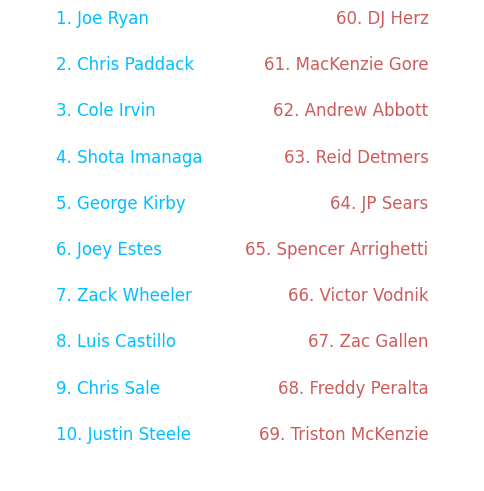

In [175]:
import matplotlib.pyplot as plt

n_total = sc_agg_FF.shape[0]

list1 = list(sc_agg_FF.head(10)['pitcher_name'].to_numpy())
list2 = list(sc_agg_FF.tail(10)['pitcher_name'].to_numpy())

# prepend ranking
list1 = [f"{i + 1}. {name}" for i, name in enumerate(list1)]
list2 = [f"{i + 1 + n_total - len(list2)}. {name}" for i, name in enumerate(list2)]

fig, ax = plt.subplots(figsize=(6, 6))

for i, name in enumerate(list1):
    ax.text(0.1, 1 - (i * 0.1), name, ha='left', va='center', fontsize=12, color='deepskyblue')

for i, name in enumerate(list2):
    ax.text(0.9, 1 - (i * 0.1), name, ha='right', va='center', fontsize=12, color='indianred')

ax.axis('off')
